In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



In [3]:
# Add tensorboard stuff
%load_ext tensorboard
import datetime

#rm -rf ./logs/


In [4]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [5]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [6]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [7]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [8]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,30,31,32,33,35)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [9]:
x_train.shape

(28044, 60, 80, 3)

In [10]:
# tlen = len(xtemp[0])-2 +len(xtemp[1])-2+len(xtemp[2])+len(xtemp[3]) #remove 2 samples from 24
# x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
# x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
# x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

tlen = len(xtemp[0]) +len(xtemp[1])+len(xtemp[2])+len(xtemp[3])+len(xtemp[4])+len(xtemp[5]) #remove 2 samples from 24 and 3 from 25
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
xrun = len(xtemp[0])
x_train[:xrun,:,:,:] = xtemp[0][:xrun,:,:,:]
xrun1 = xrun + len(xtemp[1])
x_train[xrun:xrun1,:,:,:]=xtemp[1][:xrun1-xrun,:,:,:]
xrun2 = xrun1 + len(xtemp[2])
x_train[xrun1:xrun2,:,:,:] = xtemp[2][:xrun2-xrun1,:,:,:]
xrun3 = xrun2 + len(xtemp[3])
x_train[xrun2:xrun3,:,:,:] = xtemp[3][:xrun3-xrun2,:,:,:]
xrun4 = xrun3 + len(xtemp[4])
x_train[xrun3:xrun4,:,:,:] = xtemp[4][:xrun4-xrun3,:,:,:]
xrun5 = xrun4 + len(xtemp[5])
x_train[xrun4:xrun5,:,:,:] = xtemp[5][:xrun5-xrun4,:,:,:]

In [11]:
print(x_train.shape)
del xtemp

(82381, 60, 80, 3)


# read fcss data

In [12]:


n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + "/" +test_str
    fcss_data_dir = data_dir + "/fcss_processed_leo_" + test_str + '_' + date[i] + '.txt'
    xfcss_gttemp = pd.read_csv(fcss_data_dir)
    xfcss_gt[i]=xfcss_gttemp
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [13]:
# tmpdata.head()

In [14]:
xfcss_train.shape

(82381, 6)

# Read Output Data


In [15]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
y_train = np.zeros((tlen,1))
xrun = len(y_gt[0])
y_train[:xrun] = y_gt[0][:xrun]
xrun1 = xrun + len(y_gt[1])
y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
xrun2 = xrun1 + len(y_gt[2])
y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
xrun3 = xrun2 + len(y_gt[3])
y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
xrun4 = xrun3 + len(y_gt[4])
y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
xrun5 = xrun4 + len(y_gt[5])
y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
del y_gt

In [16]:
## Saturate output
def saturate(theta, min_val, max_val):
    for i in range(len(theta)):
        if theta[i] < min_val:
            theta[i] = min_val
            continue
        if theta[i] > max_val:
            theta[i] = max_val
            continue
    return theta
            
min_val = -50
max_val = 50
    
y_train = saturate(y_train, min_val, max_val)

In [17]:
print(x_train.shape)
print(xfcss_train.shape)
print(y_train.shape)

(82381, 60, 80, 3)
(82381, 6)
(82381, 1)


In [18]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [19]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [20]:
sc_X2 = StandardScaler()
sc_y = StandardScaler()

In [21]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)

In [22]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)


# Regress using Neural Network

In [21]:
x_train.shape

(82381, 60, 80, 3)

In [28]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
from tensorflow.keras.models import Model
dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(100)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(100)(model_comb)
model_comb = Activation('relu')(model_comb)
model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(1)(model_comb)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 30, 40, 16)   0           activation[0][0]                 
______________________________________________________________________________________________

In [30]:
epochs = int(30000)
batch_size = 256
import keras
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit([X,X2], y,batch_size=batch_size, epochs = epochs,callbacks = [callback,tensorboard_callback],validation_data = ([Xvalid,Xvalid2], y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 65904 samples, validate on 16477 samples
Epoch 1/30000
65904/65904 - 10s - loss: 0.5302 - mse: 0.6598 - mae: 0.5302 - val_loss: 0.4607 - val_mse: 0.4938 - val_mae: 0.4607
Epoch 2/30000
65904/65904 - 7s - loss: 0.4527 - mse: 0.4947 - mae: 0.4527 - val_loss: 0.4123 - val_mse: 0.4230 - val_mae: 0.4123
Epoch 3/30000
65904/65904 - 7s - loss: 0.4151 - mse: 0.4362 - mae: 0.4151 - val_loss: 0.3796 - val_mse: 0.3772 - val_mae: 0.3796
Epoch 4/30000
65904/65904 - 7s - loss: 0.3921 - mse: 0.4033 - mae: 0.3921 - val_loss: 0.3629 - val_mse: 0.3607 - val_mae: 0.3629
Epoch 5/30000
65904/65904 - 7s - loss: 0.3776 - mse: 0.3835 - mae: 0.3776 - val_loss: 0.3552 - val_mse: 0.3517 - val_mae: 0.3552
Epoch 6/30000
65904/65904 - 7s - loss: 0.3662 - mse: 0.3691 - mae: 0.3662 - val_loss: 0.3422 - val_mse: 0.3351 - val_mae: 0.3422
Epoch 7/30000
65904/65904 - 7s - loss: 0.3564 - mse: 0.3550 - mae: 0.3564 - val_loss: 0.3338 - val_mse: 0.3215 - val_mae: 0.3338
Epoch 8/30000
65904/65904 - 7s - loss: 0.3506 

Epoch 64/30000
65904/65904 - 7s - loss: 0.1972 - mse: 0.1400 - mae: 0.1972 - val_loss: 0.1917 - val_mse: 0.1299 - val_mae: 0.1917
Epoch 65/30000
65904/65904 - 7s - loss: 0.1955 - mse: 0.1396 - mae: 0.1955 - val_loss: 0.1872 - val_mse: 0.1284 - val_mae: 0.1872
Epoch 66/30000
65904/65904 - 7s - loss: 0.1956 - mse: 0.1381 - mae: 0.1956 - val_loss: 0.1916 - val_mse: 0.1297 - val_mae: 0.1916
Epoch 67/30000
65904/65904 - 7s - loss: 0.1933 - mse: 0.1356 - mae: 0.1933 - val_loss: 0.1836 - val_mse: 0.1245 - val_mae: 0.1836
Epoch 68/30000
65904/65904 - 7s - loss: 0.1930 - mse: 0.1357 - mae: 0.1930 - val_loss: 0.1915 - val_mse: 0.1297 - val_mae: 0.1915
Epoch 69/30000
65904/65904 - 7s - loss: 0.1930 - mse: 0.1349 - mae: 0.1930 - val_loss: 0.1902 - val_mse: 0.1305 - val_mae: 0.1902
Epoch 70/30000
65904/65904 - 7s - loss: 0.1910 - mse: 0.1319 - mae: 0.1910 - val_loss: 0.1872 - val_mse: 0.1253 - val_mae: 0.1872
Epoch 71/30000
65904/65904 - 7s - loss: 0.1904 - mse: 0.1312 - mae: 0.1904 - val_loss: 0.1

Epoch 127/30000
65904/65904 - 7s - loss: 0.1588 - mse: 0.0974 - mae: 0.1588 - val_loss: 0.1726 - val_mse: 0.1088 - val_mae: 0.1726
Epoch 128/30000
65904/65904 - 7s - loss: 0.1577 - mse: 0.0957 - mae: 0.1577 - val_loss: 0.1691 - val_mse: 0.1064 - val_mae: 0.1691
Epoch 129/30000
65904/65904 - 7s - loss: 0.1589 - mse: 0.0968 - mae: 0.1589 - val_loss: 0.1673 - val_mse: 0.1063 - val_mae: 0.1673
Epoch 130/30000
65904/65904 - 7s - loss: 0.1577 - mse: 0.0958 - mae: 0.1577 - val_loss: 0.1709 - val_mse: 0.1116 - val_mae: 0.1709
Epoch 131/30000
65904/65904 - 7s - loss: 0.1582 - mse: 0.0962 - mae: 0.1582 - val_loss: 0.1716 - val_mse: 0.1093 - val_mae: 0.1716
Epoch 132/30000
65904/65904 - 7s - loss: 0.1578 - mse: 0.0955 - mae: 0.1578 - val_loss: 0.1673 - val_mse: 0.1068 - val_mae: 0.1673
Epoch 133/30000
65904/65904 - 7s - loss: 0.1574 - mse: 0.0959 - mae: 0.1574 - val_loss: 0.1642 - val_mse: 0.1034 - val_mae: 0.1642
Epoch 134/30000
65904/65904 - 7s - loss: 0.1581 - mse: 0.0953 - mae: 0.1581 - val_l

Epoch 190/30000
65904/65904 - 7s - loss: 0.1418 - mse: 0.0821 - mae: 0.1418 - val_loss: 0.1662 - val_mse: 0.1025 - val_mae: 0.1662
Epoch 191/30000
65904/65904 - 7s - loss: 0.1429 - mse: 0.0832 - mae: 0.1429 - val_loss: 0.1606 - val_mse: 0.1011 - val_mae: 0.1606
Epoch 192/30000
65904/65904 - 7s - loss: 0.1425 - mse: 0.0828 - mae: 0.1425 - val_loss: 0.1620 - val_mse: 0.1010 - val_mae: 0.1620
Epoch 193/30000
65904/65904 - 7s - loss: 0.1421 - mse: 0.0821 - mae: 0.1421 - val_loss: 0.1638 - val_mse: 0.1017 - val_mae: 0.1638
Epoch 194/30000
65904/65904 - 7s - loss: 0.1424 - mse: 0.0830 - mae: 0.1424 - val_loss: 0.1627 - val_mse: 0.1016 - val_mae: 0.1627
Epoch 195/30000
65904/65904 - 7s - loss: 0.1425 - mse: 0.0829 - mae: 0.1425 - val_loss: 0.1660 - val_mse: 0.1026 - val_mae: 0.1660
Epoch 196/30000
65904/65904 - 7s - loss: 0.1412 - mse: 0.0817 - mae: 0.1412 - val_loss: 0.1701 - val_mse: 0.1047 - val_mae: 0.1701
Epoch 197/30000
65904/65904 - 7s - loss: 0.1412 - mse: 0.0817 - mae: 0.1412 - val_l

Epoch 253/30000
65904/65904 - 7s - loss: 0.1327 - mse: 0.0758 - mae: 0.1327 - val_loss: 0.1698 - val_mse: 0.1052 - val_mae: 0.1698
Epoch 254/30000
65904/65904 - 7s - loss: 0.1324 - mse: 0.0754 - mae: 0.1324 - val_loss: 0.1603 - val_mse: 0.0994 - val_mae: 0.1603
Epoch 255/30000
65904/65904 - 7s - loss: 0.1319 - mse: 0.0749 - mae: 0.1319 - val_loss: 0.1614 - val_mse: 0.0986 - val_mae: 0.1614
Epoch 256/30000
65904/65904 - 7s - loss: 0.1325 - mse: 0.0754 - mae: 0.1325 - val_loss: 0.1638 - val_mse: 0.1011 - val_mae: 0.1638
Epoch 257/30000
65904/65904 - 7s - loss: 0.1327 - mse: 0.0757 - mae: 0.1327 - val_loss: 0.1706 - val_mse: 0.1028 - val_mae: 0.1706
Epoch 258/30000
65904/65904 - 7s - loss: 0.1330 - mse: 0.0757 - mae: 0.1330 - val_loss: 0.1682 - val_mse: 0.1037 - val_mae: 0.1682
Epoch 259/30000
65904/65904 - 7s - loss: 0.1314 - mse: 0.0751 - mae: 0.1314 - val_loss: 0.1619 - val_mse: 0.1018 - val_mae: 0.1619
Epoch 260/30000
65904/65904 - 7s - loss: 0.1324 - mse: 0.0752 - mae: 0.1324 - val_l

In [32]:
#%tensorboard --logdir logs/fit

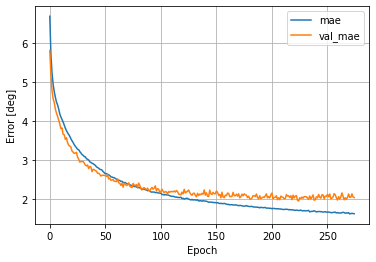

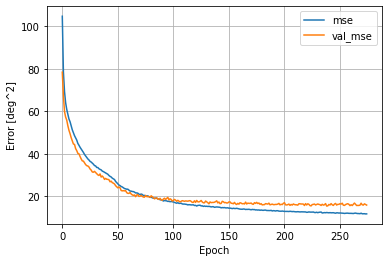

In [33]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

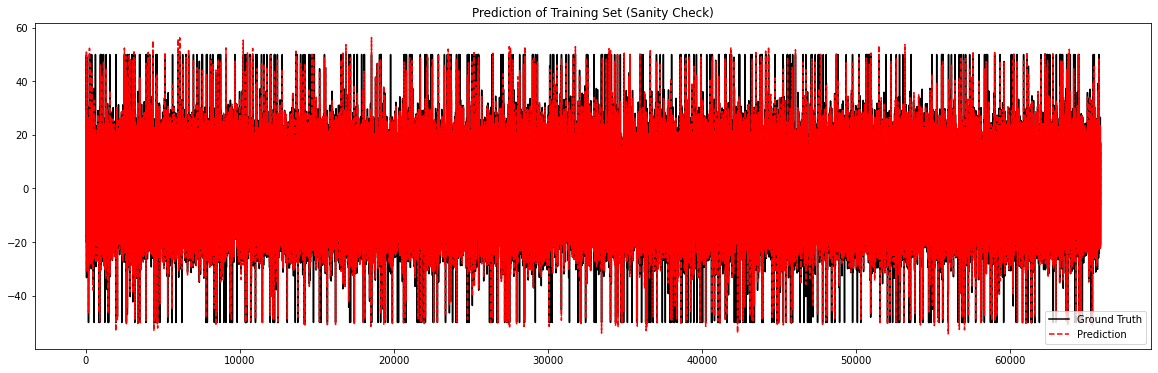

Average error is 0.05 degrees
Root Mean Squared Error is 1.15 degrees
Mean Absolute Error is 1.15 degrees


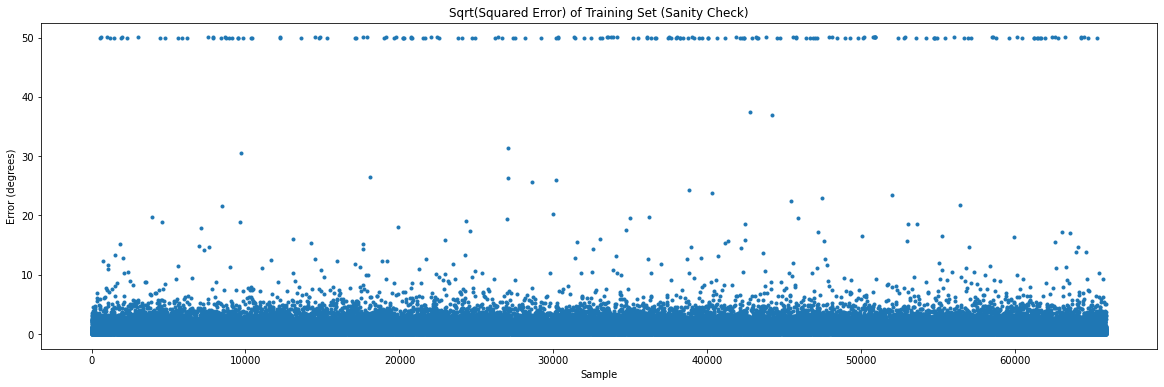

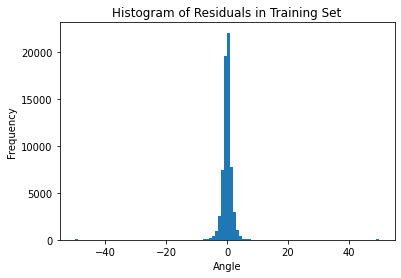

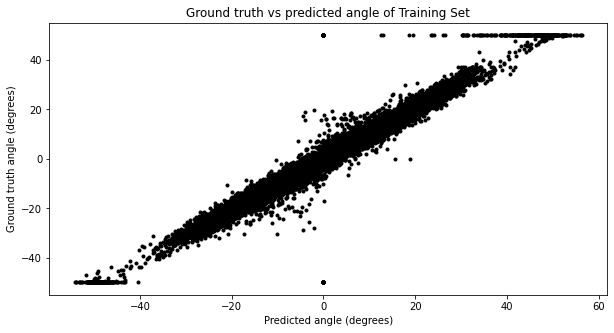

In [34]:

# sanity check with 80% data
Xtrainz = Trainset
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

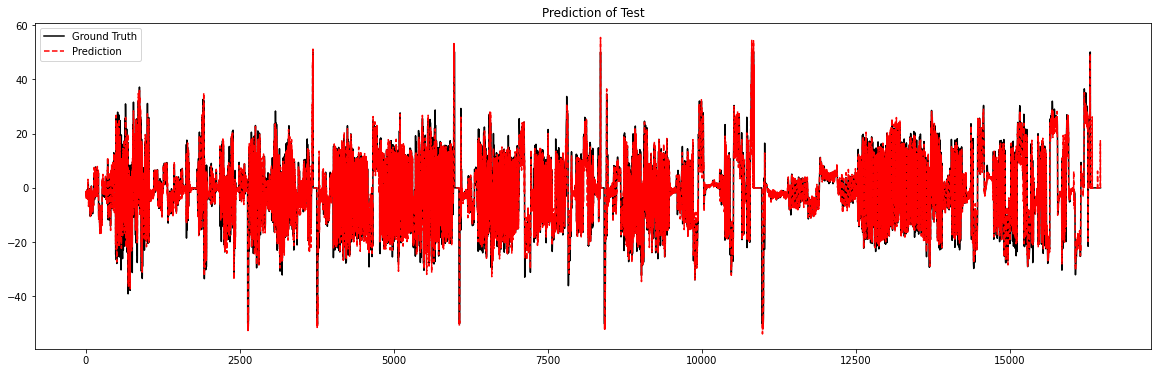

Average error is 0.08 degrees
Root Mean Squared Error is 1.96 degrees
Mean Absolute Error is 1.96 degrees


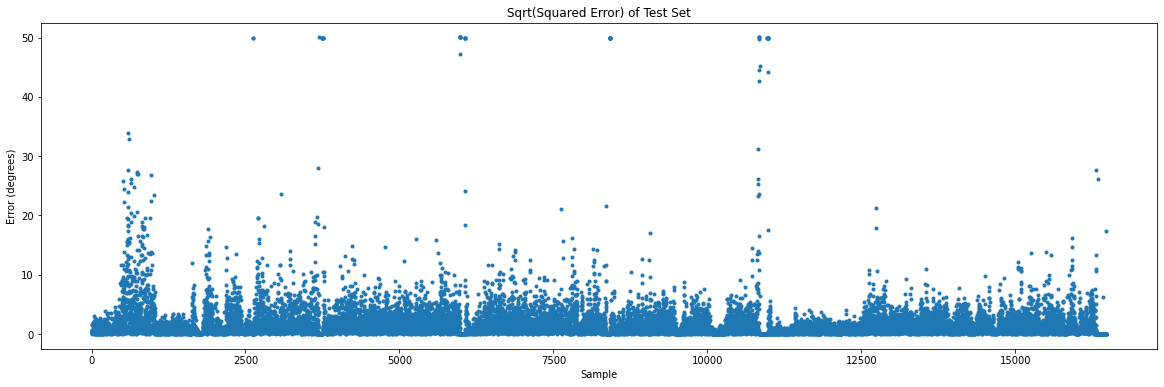

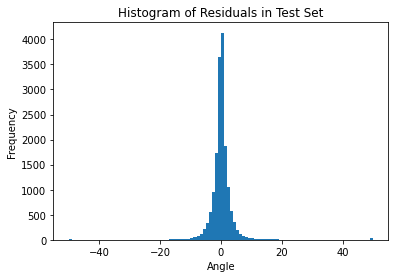

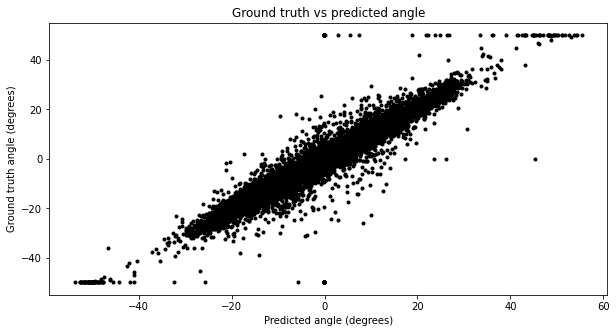

In [35]:
# Redo test set
Xtest = Testset
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [36]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v18.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
        
    model.save('depthforcemodel_cnn3v18.h5') 